In [ ]:

import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose, STL

warnings.filterwarnings('ignore')

The Data

In [2]:
df = pd.read_csv('data/train.csv')
df.dropna(inplace=True)
df.shape

(1017209, 9)

<Axes: >

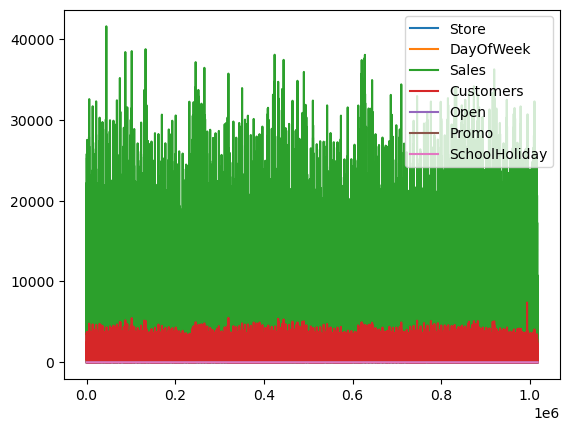

In [3]:
df.plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
df_g_s = df.query("DayOfWeek == 7 and Open == 1").groupby(['Store','DayOfWeek'])[['Sales']]
df_g_s.value_counts()

Store  DayOfWeek  Sales
85     7          11528    2
                  7303     1
                  13194    1
                  13267    1
                  13275    1
                          ..
1099   7          4698     1
                  4703     1
                  4761     1
                  4812     1
                  7465     1
Length: 3535, dtype: int64

In [6]:
stores_df = df.set_index(pd.to_datetime(df['Date'])).drop('Date', axis = 1)

In [7]:
stores_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


In [8]:
store_1 = stores_df[(stores_df['Store'] == 209)][['Sales']]
store_1.dropna(inplace=True)
store_1.sort_index(inplace=True)

In [9]:
store_1.head()

,Sales
Date,
2013-01-01,0
2013-01-02,5838
2013-01-03,5703
2013-01-04,5417
2013-01-05,3964


<Axes: title={'center': 'Store Daily Sales vs time'}, xlabel='Date'>

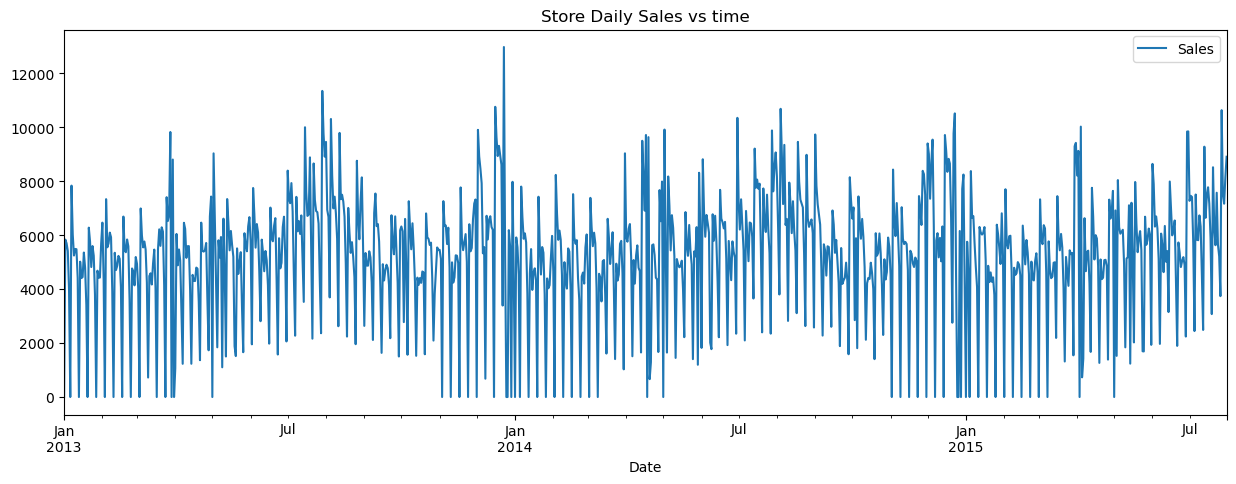

In [10]:
store_1.plot(figsize=(15,5), title='Store Daily Sales vs time')

#### Train/Test split

In [11]:
y_hist, y_future = train_test_split(store_1, shuffle=False)

In [12]:
# Answer check
print("History\n=========")
print(y_hist.tail())
print("Future\n==========")
print(y_future.head())

History
            Sales
Date             
2014-12-03   7355
2014-12-04   8713
2014-12-05   9547
2014-12-06   6305
2014-12-07      0
Future
            Sales
Date             
2014-12-08   5802
2014-12-09   6077
2014-12-10   5180
2014-12-11   5903
2014-12-12   5034


### Stationarity of residuals in a decomposition model

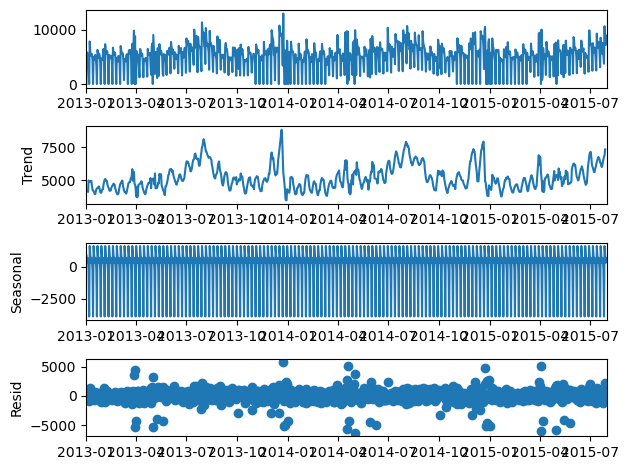

In [13]:
periods = 12
store_decmp = seasonal_decompose(store_1, model='additive')
store_decmp.plot();

Text(0.5, 1.0, 'Trend with Store Data')

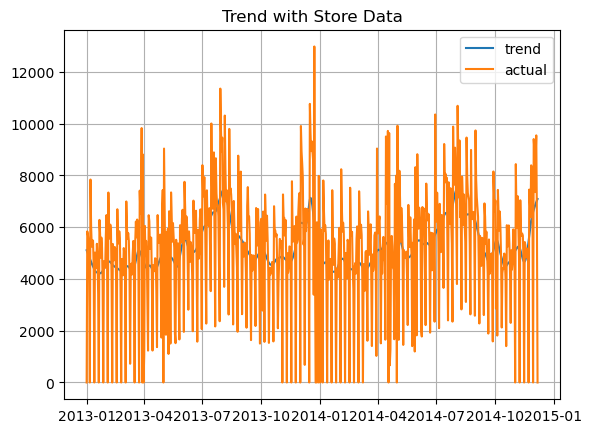

In [14]:
stl = STL(y_hist['Sales'], period = periods)
results = stl.fit()
## Answer check
plt.plot(results.trend, label = 'trend')
plt.plot(y_hist, label = 'actual')
plt.grid()
plt.legend()
plt.title('Trend with Store Data')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

Yes
pval: 6.8696752994042e-17


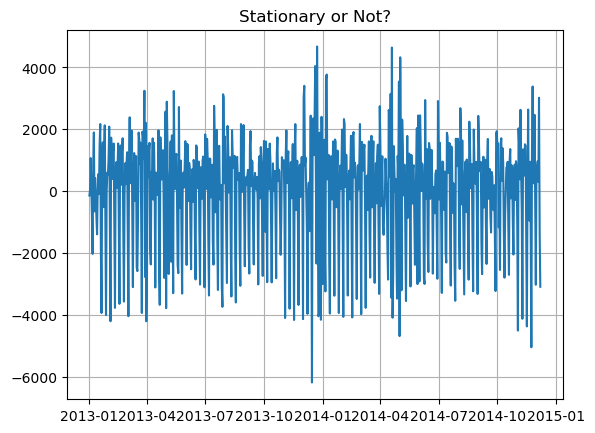

In [15]:
plt.plot(results.resid)
plt.grid()
plt.title('Stationary or Not?');
print('Yes' if adfuller(results.resid)[1] < 0.05 else 'Not')
print(f"pval: {adfuller(results.resid)[1]}")

pval: 0.06647406016645246
Stationary: Yes


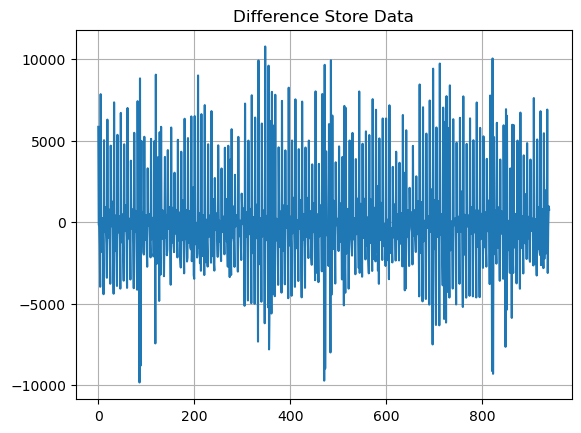

In [16]:
min_diff = store_1.diff().dropna()
plt.plot(min_diff.values)
plt.title('Difference Store Data')
plt.grid();
print(f"pval: {adfuller(y_hist)[1]}")
print(f"Stationary: {'Yes' if adfuller(min_diff)[1] < 0.05 else 'Not'}")

#### Assumptions of Linearity

In [17]:
pval = adfuller(y_hist)[1]
pval

0.06647406016645246

### Autocorrelation and Partial Autocorrelation

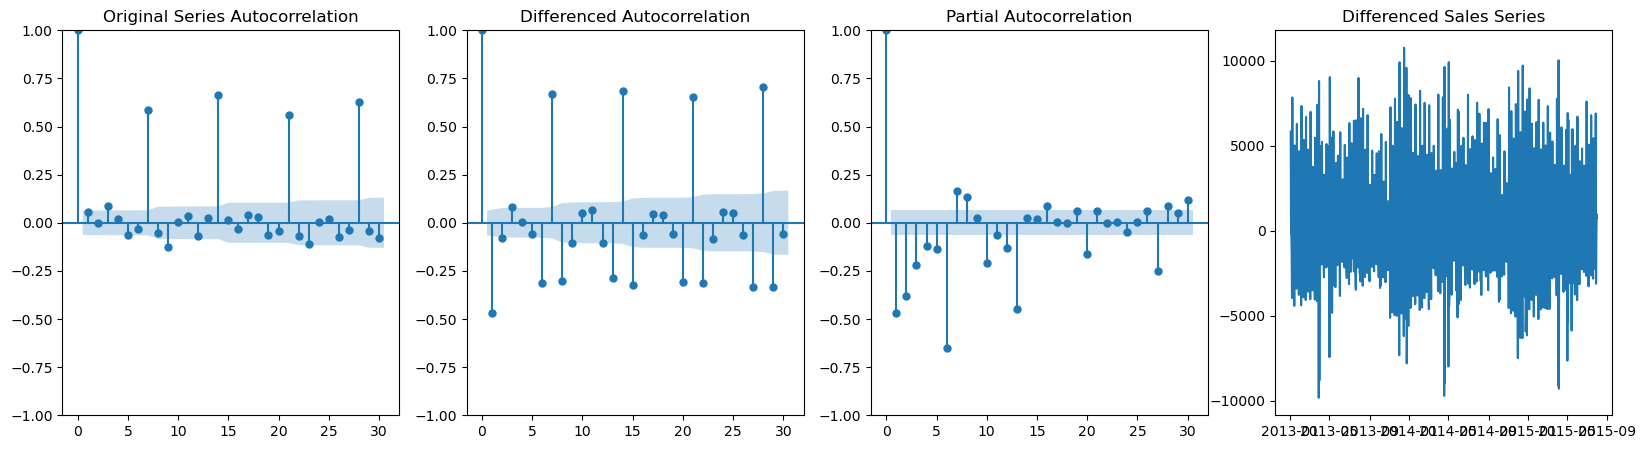

In [18]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(store_1, ax = ax[0]);
ax[0].set_title('Original Series Autocorrelation')
plot_acf(store_1.diff().dropna(), ax = ax[1]);
ax[1].set_title('Differenced Autocorrelation')
plot_pacf(store_1.diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(store_1.diff().dropna())
ax[3].set_title('Differenced Sales Series');

In [19]:
X_train, X_test = store_1.iloc[:-30], store_1.iloc[-30:]
arma = ARIMA(X_train.diff(), order = (2, 0, 5), freq = 'D').fit()
preds = arma.forecast(len(X_test))
mse_test = mean_squared_error(preds, X_test)
print(mse_test)

44408940.689077534


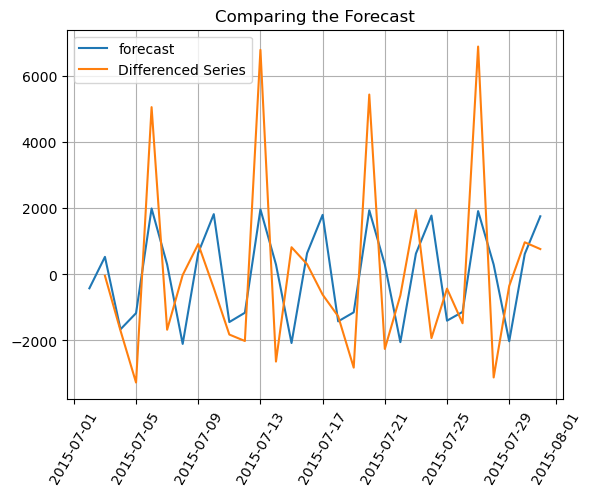

In [20]:
plt.plot(arma.forecast(steps = len(X_test)), label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.title('Comparing the Forecast')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


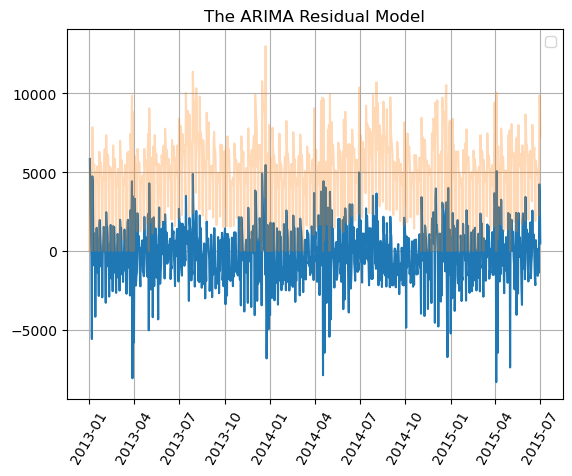

In [21]:
plt.plot(X_train.index, arma.resid)
plt.plot(X_train.index, X_train, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The ARIMA Residual Model')
plt.legend()
plt.grid();

### A Model with Seasonality

In [22]:
X_train_z, X_test_z = store_1.iloc[-700:-30], store_1.iloc[-30:]
sarima = SARIMAX(X_train_z,  order=(2, 0, 5), seasonal_order=(2, 0, 5, 7)).fit(disp=0)
print(sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  670
Model:             SARIMAX(2, 0, 5)x(2, 0, 5, 7)   Log Likelihood               -6006.660
Date:                           Wed, 15 Nov 2023   AIC                          12043.320
Time:                                   02:43:02   BIC                          12110.929
Sample:                               08-31-2013   HQIC                         12069.507
                                    - 07-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0060      0.751      0.008      0.994      -1.466       1.478
ar.L2          0.9939      0.752      1.322

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model MAE: 962.8192488373481
Model RMSE: 1471.2620924922887
Model AICC: 12044.05349774029


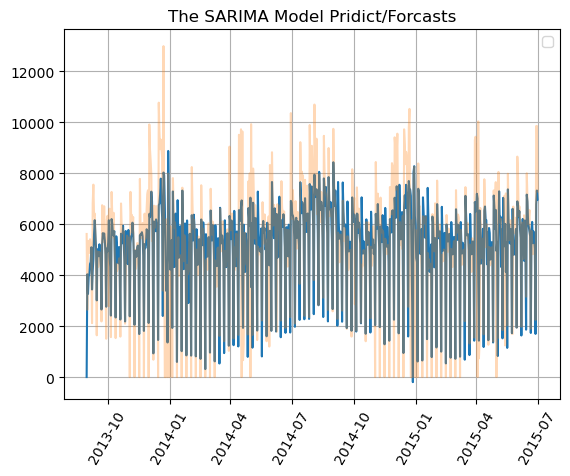

In [23]:
plt.plot(X_train_z.index, sarima.predict())
plt.plot(X_train_z.index, X_train_z, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model Pridict/Forcasts')
plt.legend()
plt.grid();
print(f"Model MAE: {sarima.mae}")
#print(f"Model MSE: {sarima.mse}")
print(f"Model RMSE: {np.sqrt(sarima.mse)}")
print(f"Model AICC: {sarima.aicc}")

In [24]:
dir(sarima)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_params_variance',
 '_rank',
 '_states',
 '_use_t',
 'aic',
 'aicc',
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


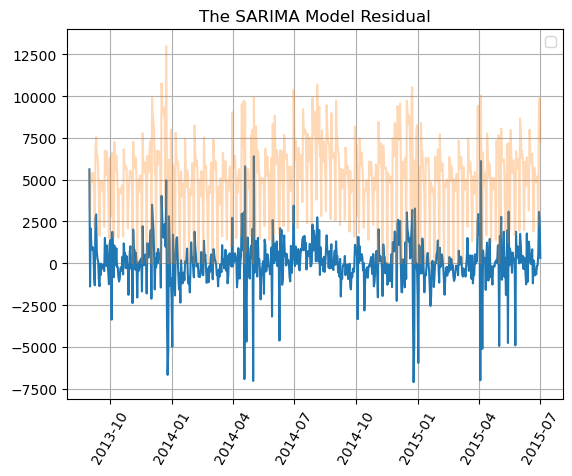

In [25]:
plt.plot(X_train_z.index, sarima.resid)
plt.plot(X_train_z.index, X_train_z, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model Residual')
plt.legend()
plt.grid();

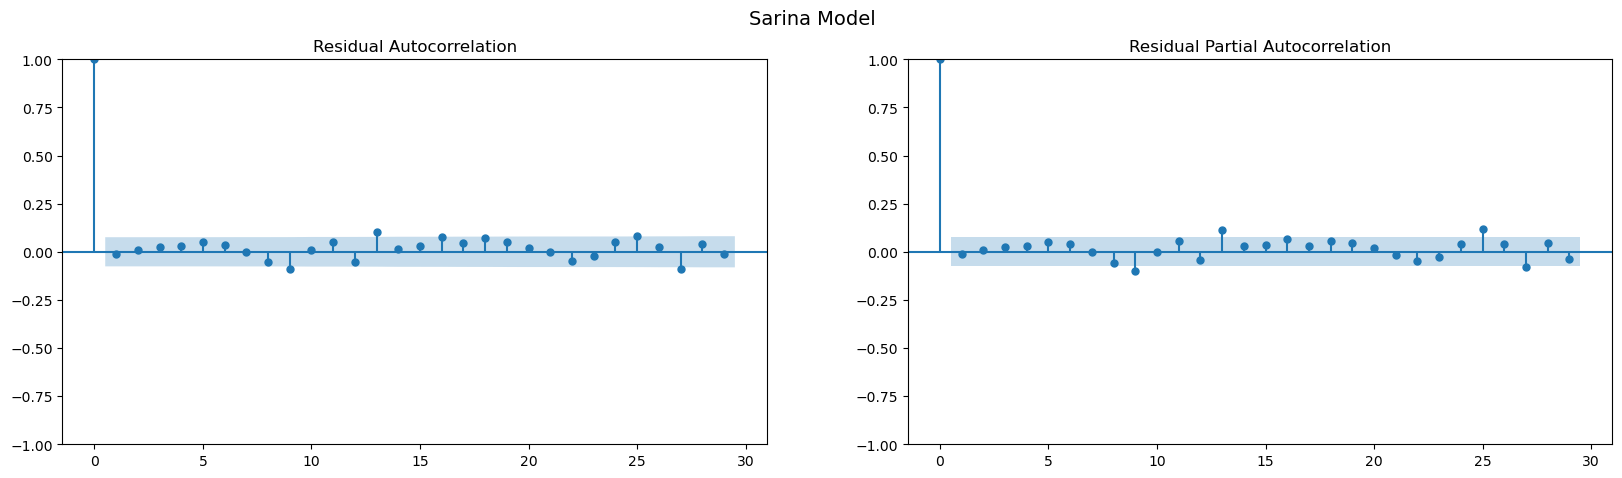

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

plot_acf(sarima.resid, ax = ax[0]);
ax[0].set_title('Residual Autocorrelation')
plot_pacf(sarima.resid, ax = ax[1]);
ax[1].set_title('Residual Partial Autocorrelation')
fig.suptitle('Sarina Model', fontsize = 14, horizontalalignment='center')
plt.show()

In [27]:
dir(sarima)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_params_variance',
 '_rank',
 '_states',
 '_use_t',
 'aic',
 'aicc',
 

### Examining acf and pacf

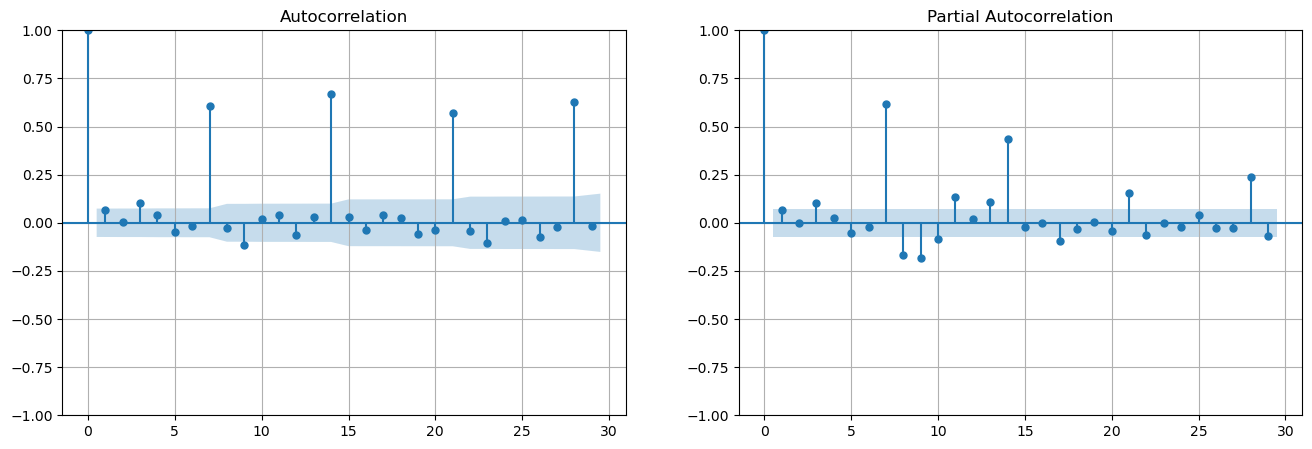

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y_hist, ax = ax[0]);
ax[0].grid()
plot_pacf(y_hist, ax = ax[1], method = 'ywm');
ax[1].grid()

In [29]:
arma = ARIMA(y_hist['Sales'], order = (2, 0, 5)).fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  706
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -6327.804
Date:                Wed, 15 Nov 2023   AIC                          12673.609
Time:                        02:43:03   BIC                          12714.645
Sample:                    01-01-2013   HQIC                         12689.466
                         - 12-07-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5218.2887    152.171     34.292      0.000    4920.039    5516.539
ar.L1         -0.4439      0.005    -81.196      0.000      -0.455      -0.433
ar.L2         -0.9968      0.003   -295.253      0.0

### Making Predictions

In [30]:
hist_preds = arma.predict()

Model MAE: 1439.7599630587597
Model RMSE: 1859.8268182047939
Model AICC: 12673.867432532883


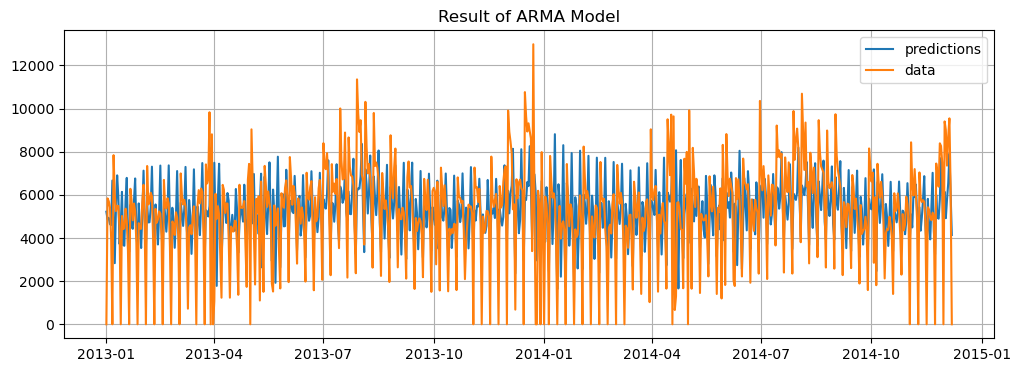

In [31]:
# Answer check
print(f"Model MAE: {arma.mae}")
print(f"Model RMSE: {np.sqrt(arma.mse)}")
print(f"Model AICC: {arma.aicc}")
plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'predictions')
plt.plot(y_hist, label = 'data')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');

### Forecasting with the ARMA model

In [32]:
future_preds = arma.forecast(steps = len(y_future))

Model MAE: 1439.7599630587597
Model RMSE: 1859.8268182047939
Model AICC: 12673.867432532883


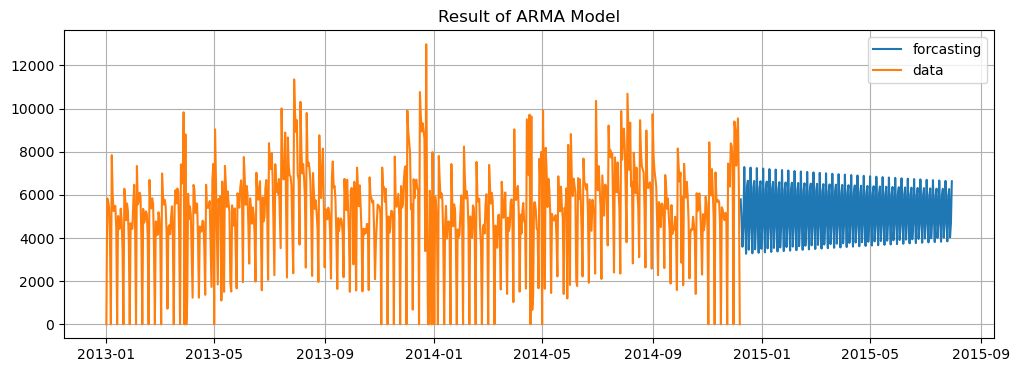

In [33]:
# Answer check
plt.figure(figsize = (12, 4))
plt.plot(future_preds, label = 'forcasting')
plt.plot(y_hist, label = 'data')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');
print(f"Model MAE: {arma.mae}")
print(f"Model RMSE: {np.sqrt(arma.mse)}")
print(f"Model AICC: {arma.aicc}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


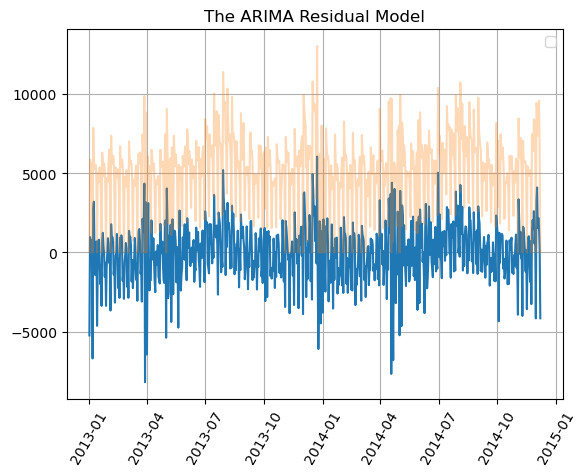

In [34]:
plt.plot(y_hist.index, arma.resid.values)
plt.plot(y_hist.index, y_hist, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The ARIMA Residual Model')
plt.legend()
plt.grid();

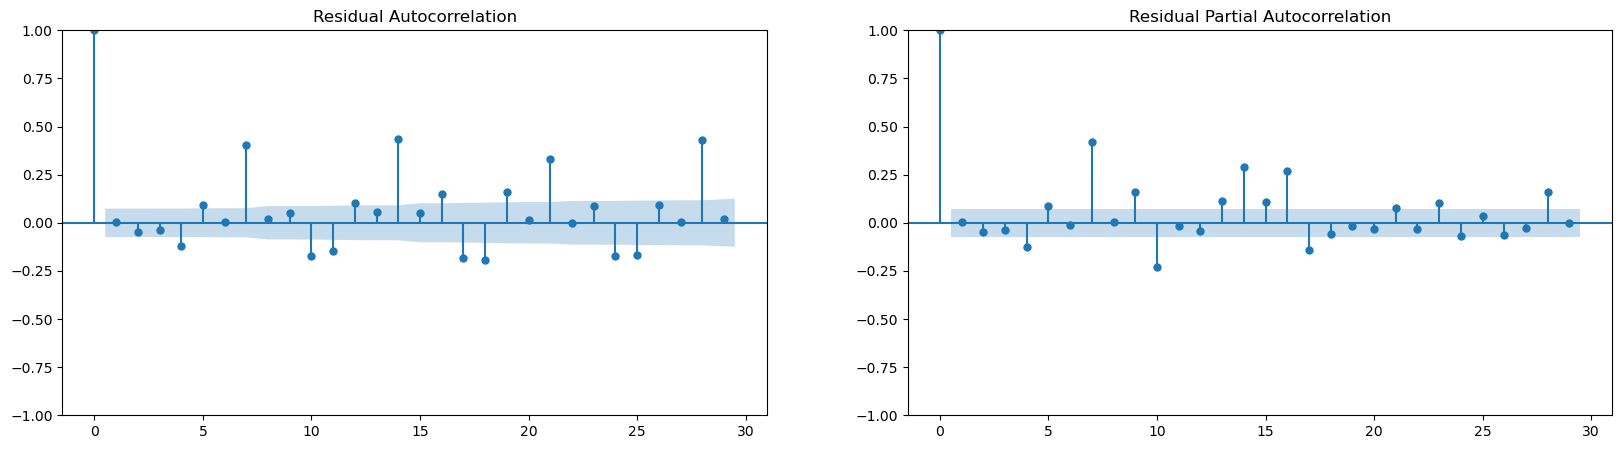

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
plot_acf(arma.resid, ax = ax[0]);
ax[0].set_title('Residual Autocorrelation')
plot_pacf(arma.resid, ax = ax[1]);
ax[1].set_title('Residual Partial Autocorrelation');

### Errors and Autocorrelation

In [36]:
dir(arma)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_exog',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_params_variance',
 '_rank',
 '_states',
 '_use_t',
 

<Axes: xlabel='Date'>

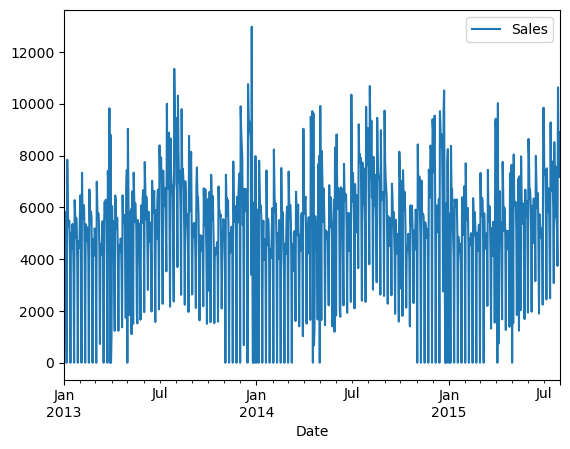

In [37]:
store_1.plot()

<Axes: xlabel='Date'>

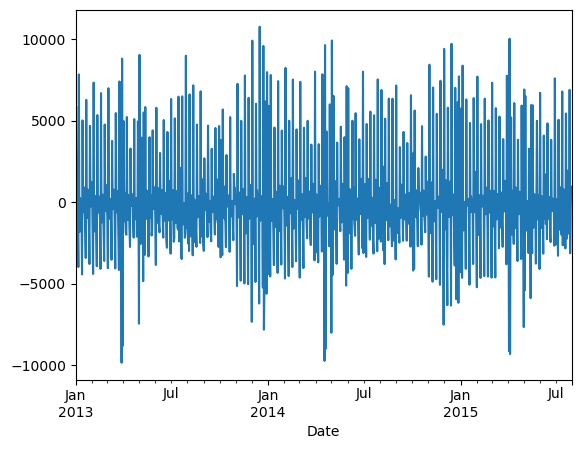

In [38]:
y = store_1['Sales'].diff()
y.plot()

<Axes: >

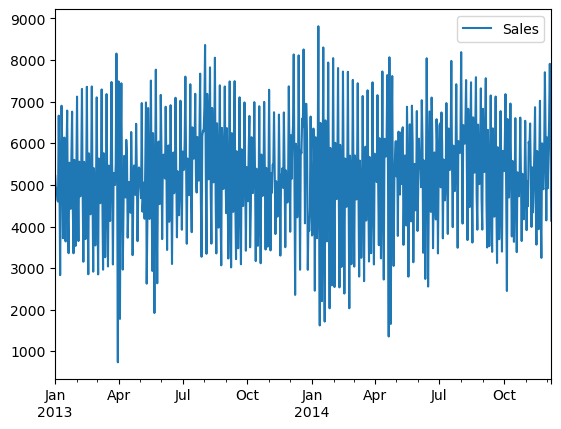

In [39]:
hist_preds = pd.DataFrame(hist_preds)
hist_preds.columns = ['Sales']
hist_preds.plot()

In [40]:
resids = y - hist_preds['Sales']
resids

2013-01-01            NaN
2013-01-02     970.254518
2013-01-03   -5064.215841
2013-01-04   -4926.326588
2013-01-05   -6053.330690
                 ...     
2015-07-27            NaN
2015-07-28            NaN
2015-07-29            NaN
2015-07-30            NaN
2015-07-31            NaN
Name: Sales, Length: 942, dtype: float64

<Axes: >

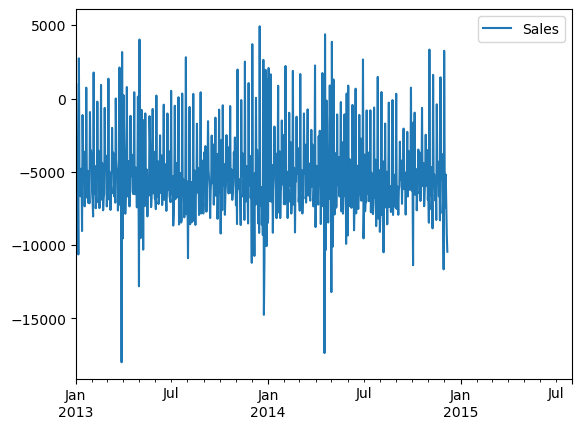

In [41]:
pd.DataFrame(resids).plot()

In [42]:
resids

2013-01-01            NaN
2013-01-02     970.254518
2013-01-03   -5064.215841
2013-01-04   -4926.326588
2013-01-05   -6053.330690
                 ...     
2015-07-27            NaN
2015-07-28            NaN
2015-07-29            NaN
2015-07-30            NaN
2015-07-31            NaN
Name: Sales, Length: 942, dtype: float64

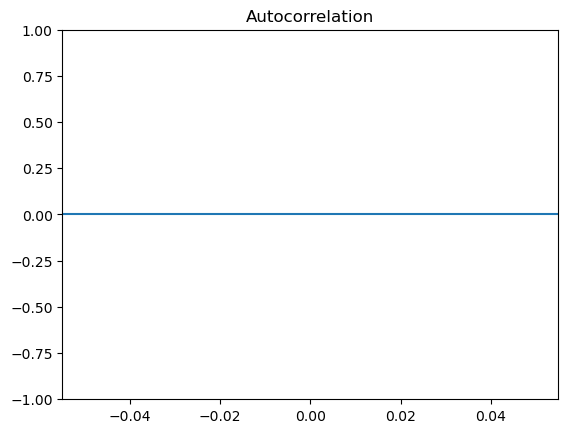

In [43]:
plot_acf(resids);